In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import copy
import math

from PIL import Image
from matplotlib import image

import pickle
import time

import pybullet as p
from envs import FrankaEnv
from envs.robot_env import RobotEnv
from envs import robot_sim
from utils.bullet_utils import add_goal, add_obstacle_ball
from utils.python_utils import merge_dicts

import controller_track_taskspace as contr
from pybullet_helpers import *
from trajectory_generator import *
from extract_density import *

device = "cpu"#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\wbaro\anaconda3\envs\bills_conda_env\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


<H1> Draw_traj function: Explanation </H1>

<H3>Purpose: </H3>

* Help you manually draw and record trajectories on a series of images

<H3> Parameters: </H3>

* view_str: A string pattern for image filenames (default is "bullet_view_{}.png"). The {} will be replaced with image indices.
* ts: An integer parameter set to 20 by default (its specific use is commented out in the code).

<H3> Mouse Callback Functions </H3>

* Left Mouse Button Down (cv2.EVENT_LBUTTONDOWN): Toggles the drawing mode on or off.
* Mouse Movement (cv2.EVENT_MOUSEMOVE): If drawing mode is active, it draws small red circles (cv2.circle) on the image at the cursor's position and records the (x, y) coordinates in list_xy.
* Left Mouse Button Up (cv2.EVENT_LBUTTONUP): Stops the drawing mode and marks the end of the current trajectory.

<H3> Termination Conditions </H3>

* Press the 'esc' key to move on to the next image

<H3> Output </H3>

* grand_traj_l: a list containing all the normalized trajectories for each image.
* First level: represents each view, so 2 nested lists
* Second level: represents each trajectory within that view 
* List -> List -> Tensor

<H3> Example Below: </H3>

1. You draw three trajectoreis for 2 views
2. The trajecotires for each view are mapped to the same trajectory index from different views
3. They are color coded as seen below

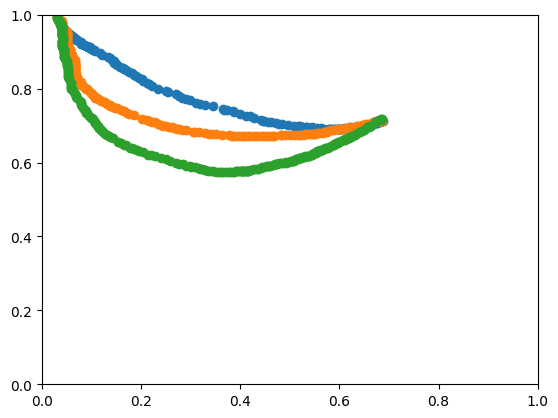

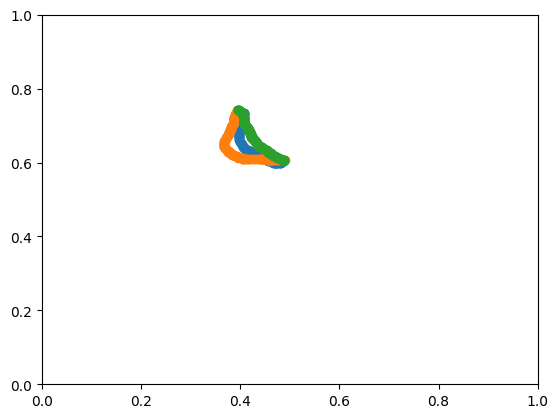

In [2]:
view_str="mobile_view_{}.png"
grand_traj_tor_r=draw_traj(view_str)

<H1> Key Variables in the Following Piece of Code: </H1>

* c_traj: a 180x2 tensor that represents the traj_ind'th trajectory in the view'th view
* traj_wt: a 180x3, which adds cur_time column to the c_traj tensor
* Each element of all_view_list has a shape of 524x3 (all_view_list[0].shape)
* So in other words: it takes the three trajectories for each views and stacks them into 1 tensor
* ACTUALLY: The different views can have different numbers of points for each trajectory in the view. So the shape of each element in the all_view_list can vary, but it is just a function of hte number of points in each trajectory for that view (which are all the same)

In [11]:
all_view_list=[]
for view in range(len(grand_traj_tor_r)):
    current_trajs=grand_traj_tor_r[view]
    view_list=[]
    for traj_ind in range(len(current_trajs)):
        c_traj=current_trajs[traj_ind][0]
        cur_time=(torch.arange(len(c_traj))*(1/len(c_traj)))[:,None]
        traj_wt=torch.cat([cur_time,c_traj],dim=-1)
        view_list.append(traj_wt.clone())
        view_tor=torch.vstack(view_list)
    all_view_list.append(view_tor.clone())
print("x")

tensor([[0.0000, 0.6900, 0.7083],
        [0.0056, 0.6867, 0.7117],
        [0.0111, 0.6833, 0.7133],
        ...,
        [0.9834, 0.2067, 0.7250],
        [0.9890, 0.2050, 0.7267],
        [0.9945, 0.2050, 0.7267]])
torch.Size([524, 3])
x


In [13]:
all_view_list[1]
print(all_view_list[0].shape)

torch.Size([524, 3])


<H1> Explaining generate_densities: </H1>

<H3> Overview: </H3>

1. Designed to process trajectory data
2. Model the trajectory data over time using an Invertible Neural Network (INN)
3. Generate density images that represent the spatial distribution of these trajectories over time

<H3> Inputs: </H3>

* all_view_list: See above for what this is, but esentially each element corresponds to a view, and is a tensor [time,x,y]

<H3> Objective: </H3>

* Use an Invertible neural network (INN) to learn the distribution of the trajectory points
* Generate density images: after training, use the INN to compute and visualize the density of trajectories across a spatial grid for various time steps

<H3> Output: </H3>

* Density Images: For each view and each specified time step, the function generates and saves a density image (.png format)
* This image visualizes the concentration of trajectory points in space at that moment

<H3> Invertible Neural Network: </H3>

* An Invertible Neural Network (INN) is a type of neural network architecture where the mapping from inputs to outputs is bijective, meaning every input corresponds to a unique output and vice versa
* They are very useful in modelling complex distributions by transforming simple distributions (like gaussian) into more intricate ones

<H1> Step by Step Flow </H1>

1. Trains an Invertible Neural Network (INN) for each view
2. Generates density images representing spatial distributions of trajectories over time
3. Convert the densitties and saves them to disk (see the traj_imgs folder)

In [8]:
%%time
generate_densities(all_view_list,noise_added=0.025)

c:\Users\wbaro\anaconda3\envs\bills_conda_env\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0: 0.188538059592247
500: -2.026167869567871
1000: -2.0848727226257324
1500: -2.1175544261932373
2000: -2.112534523010254
2500: -2.1253998279571533
3000: -2.1153573989868164
3500: -2.1110572814941406
4000: -2.0912184715270996
4500: -2.1478230953216553
creating densities for view 0
0: 0.1640305519104004
500: -2.125476837158203
1000: -2.1497867107391357
1500: -2.161738872528076
2000: -2.1828739643096924
2500: -2.165086507797241
3000: -2.1736974716186523
3500: -2.1572225093841553
4000: -2.188899517059326
4500: -2.1919026374816895
creating densities for view 1
CPU times: total: 3.03 s
Wall time: 1min 55s


<H1> Code Below </H1>

* NOTE: The poses_mobile.tar comes from the Mobile_robot_draw-Wall.ipynb file (more on this later)

<H3> Description of poses_mobile.tar </H3>

* This is generated using the Mobile_robot_draw-Wall.ipynb file
* Contains 2 4x4 transformation matrices (camera transformation matrices)

<H3> trajectory_model class: </H3>

* gamma=50: The RBF kernel width for the trajectory model.
* n_weights=100: The number of “inducing points” (or parameters) for the RBF-based trajectory.
* density_threshold=0.25: A threshold for deciding whether a pixel/voxel is considered “occupied.”
* ray_dist_threshold=0.05: Used later when deciding if two 3D points from different camera views are close enough to be the “same” point.
* device="cuda": Moves computations onto the GPU if available.

* Internally, the constructor sets up all the attributes you see in the class: focal, height, width, near, far, and so on, plus the RBF kernel features for times (self.feats) that will be used later to model a continuous trajectory in 3D.

<H3> What the double loop does: </H3>

1. Loops over n_times
2. Loops over n_views
3. Loads image for the n_times'th time and the n_views'th view
4. At the end of the loop, it creates a combined tensor of shape: (n_times, n_views, H, W): im_list_for_all. (time,view,height,width)

<H3> Raytracing: Extracting 3D Mean/Variance from the Images: </H3>

* line of code: mean_tor, var_tor = trajectory_dist.extract_mean_std_from_images(im_list_tor_all, poses)

1. Gets camera rays from poses[i_pose] with get_rays(...).
2. Samples points along each ray between near and far using sample_stratified(...).
3. Thresholds the corresponding image to see which pixels/voxels are “occupied” (where blur_im > density_threshold).
4. Collects the 3D query points that are above that density threshold for each view, producing two point clouds:
    * one for view 0
    * one for view 1.
5. Finds matching 3D points by computing pairwise distances (torch.cdist(points_0, points_1)) and filtering out pairs that are farther than ray_dist_threshold.
    * (That effectively keeps only close/fused points in 3D space that both views see as the same region.)
6. Combines the matched points, then computes the mean() and var() of the resulting 3D cluster.
7. It returns (mean_tor, var_tor), each having one entry per time step. So:

* mean_tor.shape would be (n_times, 3): the “average 3D location” of the object/region at each time step.
* var_tor.shape would be (n_times, 3): the variance in each dimension (x, y, z) at each time st





In [15]:

trajectory_dist=trajectory_model(gamma=50,n_weights=100,density_threshold=0.25,ray_dist_threshold=0.05,device="cuda")
n_times=50
n_views=2

im_list=[]
for tt in range(n_times):
    im_t_list=[]
    for ii in range(n_views):
        im = torch.tensor(image.imread("./traj_imgs/img_{}_{}.png".format(ii,tt)))[:,:,:3]
        blur_im=im[:,:,0]
        im_t_list.append(blur_im.detach().clone()[None])
        im_list_tor=torch.vstack(im_t_list)[None]
    im_list.append(im_list_tor)
im_list_tor_all=torch.vstack(im_list)

poses_all=torch.load("poses_mobile.tar")
poses=poses_all#[[0,-1]]#corresponding poses to image
#fitting the parameters
mean_tor, var_tor=trajectory_dist.extract_mean_std_from_images(im_list_tor_all, poses)


C:\Users\wbaro\AppData\Local\Temp\ipykernel_16456\2301771034.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poses_all=torch.load("poses_mobile.tar")


<H1> Fitting a Continuous Function to the Generated Distribution: </H1>

1. This function optimizes two sets of parameters stored in the model:
    * self.weights: used to generate the mean trajectory via RBF kernels.
    * self.std_weights: used to generate the standard deviation of that trajectory.
2. It does so in two stages:
    * first by matching the 3D mean of the observed trajectory data (mean_tor)
    * then by matching the std (square root of the variance, var_tor) via gradient-based optimization
* Each stage runs for n_iter steps, printing every n_display steps.

In [16]:
%%time
trajectory_dist.fit_continuous_function(mean_tor, var_tor,n_display=10000,n_iter=40000,lr_mean=1e-3,lr_std=1e-3)
trajectory_dist.fit_continuous_function(mean_tor, var_tor,n_display=10000,n_iter=20000,lr_mean=1e-4,lr_std=1e-4)

Matching trajectory distribution mean
0:2.0293312072753906
10000:9.674134162196424e-06
20000:1.2451336260710377e-05
30000:9.264601430913899e-06
Matching trajectory distribution std
0:446.931396484375
10000:0.5743567943572998
20000:0.0007202344131655991
30000:5.200939540372929e-06
Matching trajectory distribution mean
0:9.186683200823609e-06
10000:9.110286555369385e-06
Matching trajectory distribution std
0:4.081521183252335e-06
10000:4.014135356555926e-06
CPU times: total: 469 ms
Wall time: 1min 48s


In [17]:
cl_env=CleanFrankaEnv(mobile=True)
cl_env.set_up_bul(True)

True
mobile_franka
robot name: mobile_franka


<H1> Explanation of Code Directly Above and Below </H1>

<H3> Setting up initial environment and initial conditions</H3>

1.  Creates an environment where a Franka robot (often a Panda arm) is simulated, with the “mobile” parameter indicating that it likely has a mobile base or some extended functionality
2. Specifies a desired joint configuration
3. Sets that as the current joint position of the robot in the panda simulation

<H3> Loop below: </H3>

1. Loop over joints and reset states in pybullet
2. Call p.getJointInfo, which returns a tuple of information including:
    * joint name
    * joint type
    * limits
    * and so forth
3. If joint_type ==4 , then ind = ind + 1 since this corresponds to a fixed joint
4. Set the joint state: cl_env._p.resetJointState(cl_env._robot.robot_uid, ind, cur_joint_position[i])
    * This sets the current controllable joint’s position to cur_joint_position[i].
    * resetJointState forcibly overrides the joint’s angle/position in the simulation (bypassing dynamics).
    * Then ind is incremented for the next iteration.

<H3> Overall Affect: </H3>

* This code manually positions the robot in the PyBullet simulation to the joint angles specified by config["q_init"].
* By iterating over each element of cur_joint_position and skipping over fixed joints, it ensures that each active (revolute or prismatic) joint is set to the desired angle/position.


1. Initialize a PyBullet environment with a mobile Franka robot.
2. Reset it to a default state.
3. Define a custom set of joint angles (q_init) in a Python dictionary.
4. Loop through the robot’s joints in PyBullet, skipping fixed joints, and set each active joint to the angles provided.
5. This effectively moves or teleports the robot to your chosen initial pose.

In [18]:
cl_env.simple_reset()
config = {
    "q_init": [-0.1,-0.1, 0.03755247, 0.398266408, 
               0.38741508, 0.209020819,  0.922805379,
        0.46475231, 1.20273773,0.5],
}
con_q=torch.tensor(config["q_init"])
cur_joint_position=con_q
ind=0
for i in range(0,len(cur_joint_position)):
    _, joint_name, joint_type, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = p.getJointInfo(cl_env._robot.robot_uid, ind)
    if(joint_type==4):
        ind=ind+1
    cl_env._p.resetJointState(cl_env._robot.robot_uid,ind,cur_joint_position[i])
    ind=ind+1

robot name: mobile_franka


<H1> Descriptioin of the Code Below: </H1>

* Generates trajectories positioned from the start using the trajectory_dist.condition_start(start_p, 50, 100) line
* That is pretty much the relevant info

In [19]:
# cl_env.simple_reset()
# config = {
#     "q_init": [-0.03755247, -0.398266408, -0.18741508, -0.709020819,  0.522805379,
#         1.46475231, -0.20273773],
# }
# config["q_init"]=(torch.tensor(config["q_init"])+0.1*torch.randn(7)).tolist()
# print(config["q_init"])
# rand_q=np.array(config["q_init"])
# cl_env._robot.reset(rand_q, np.zeros(7))
device="cuda"
eef_id=cl_env._robot.eef_uid
pos_eef=torch.tensor(p.getLinkState(0,15)[-2])
start_p=pos_eef.to(device)#mean_tor[0].to(device)
trajs_generated=trajectory_dist.condition_start(start_p,50,100)

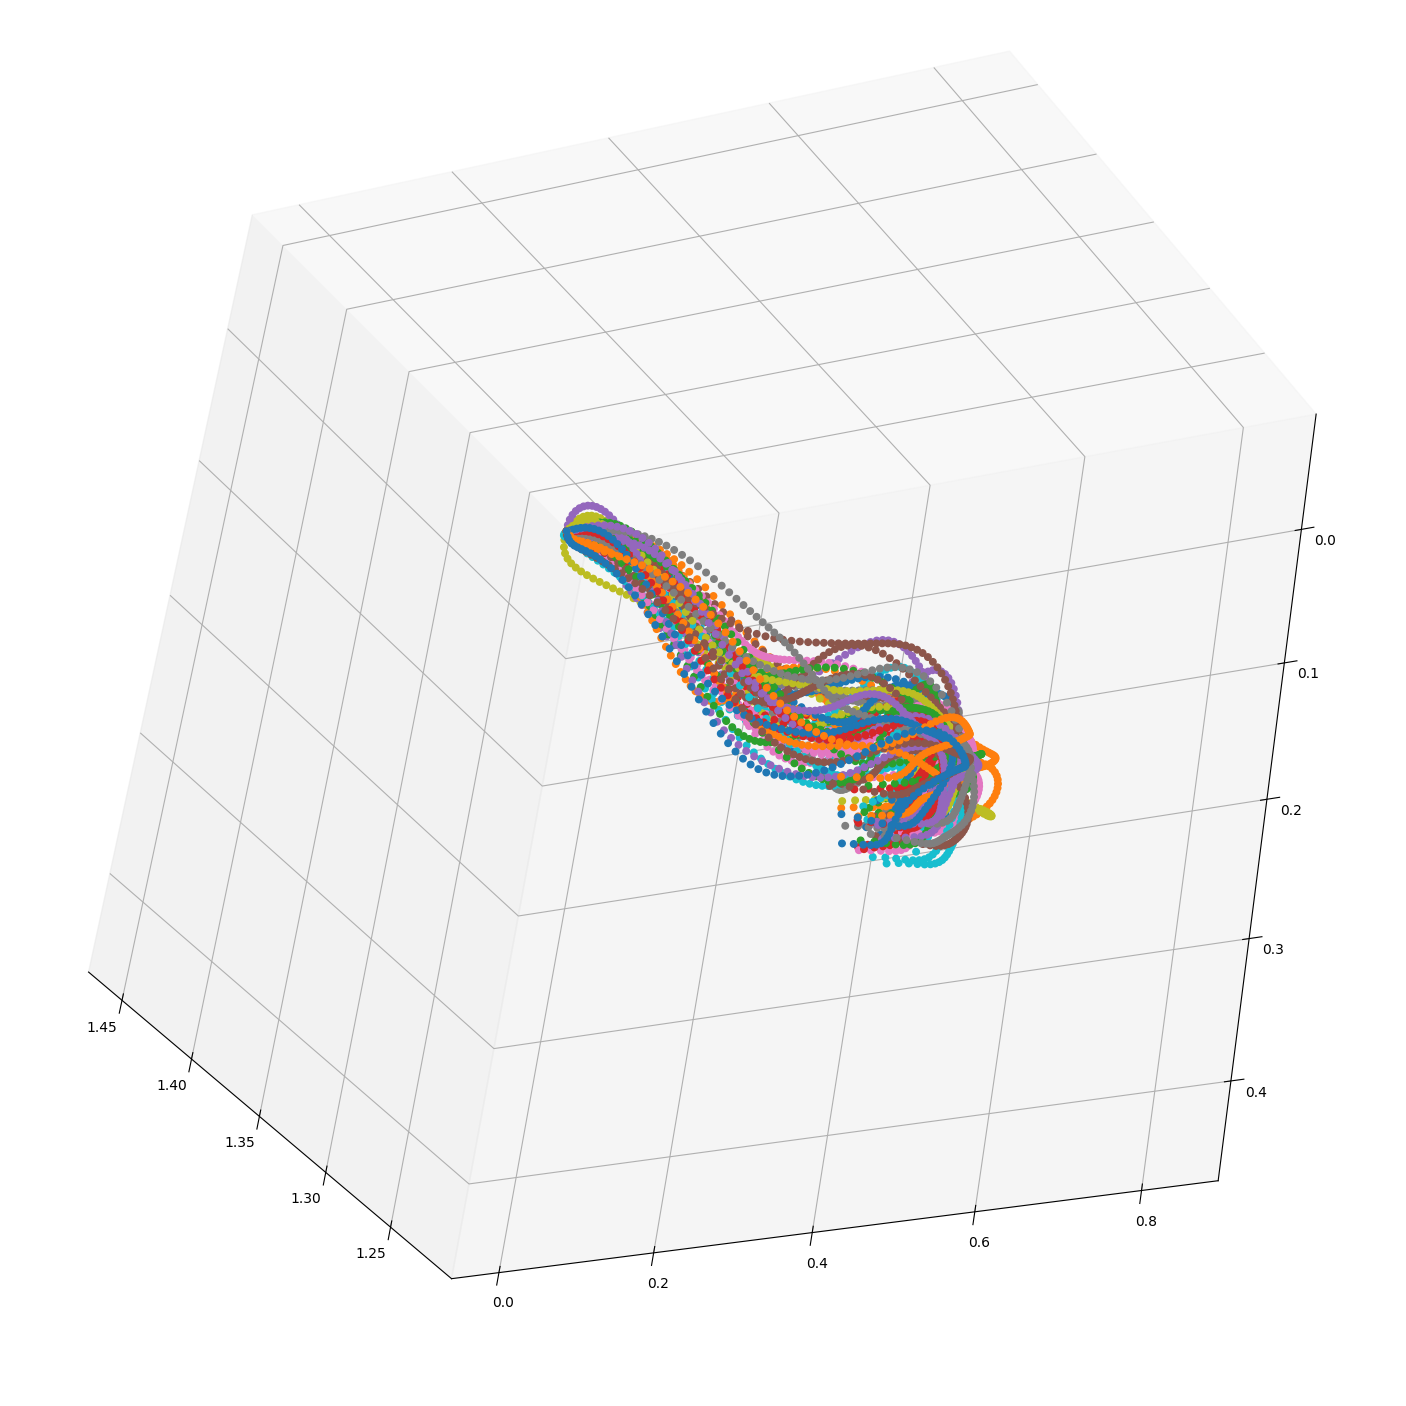

In [20]:

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(projection='3d')

for i in range(len(trajs_generated)):
    cur_pos_tor=trajs_generated[i]
    cc=ax.scatter(cur_pos_tor[:,0].cpu().detach(), 
                  cur_pos_tor[:,1].cpu().detach(), 
                  cur_pos_tor[:,2].cpu().detach(),s=22,alpha=1)
ax.view_init(45
             ,45,45)

# ax.set_xlim3d([0.1, 0.9])
# ax.set_ylim3d([-0.25, 0.25])
# ax.set_zlim3d([0., 1])

In [21]:
color=[np.random.rand(1),  np.random.rand(1), np.random.rand(1), 0.25]
test_len=np.array([0.1,2,1.8])/2
c_pos=np.array([0.5,0.,0.75])
c_ori=np.array([0,0,0,1.])
visual = p.createVisualShape(
    p.GEOM_BOX, halfExtents=test_len, rgbaColor=color)
obj=p.createMultiBody(baseMass=0,
                                    baseCollisionShapeIndex=-1,
                                    baseVisualShapeIndex=visual,
                                    basePosition=c_pos,
                                     baseOrientation=c_ori)

C:\Users\wbaro\AppData\Local\Temp\ipykernel_16456\487474224.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  visual = p.createVisualShape(


In [22]:
traj_num=0
np_traj=trajs_generated[traj_num].cpu().detach().numpy()
wp_list=[]
for i in range(len(cur_pos_tor)):
    wp=add_wp(p,cur_pos_tor[i],radius=0.01)
    wp_list.append(copy.deepcopy(wp))

<H1> Definition of the class Below (controller): </H1>

<H3> Constructor: </H3>

* Builds an inverse kinematics chain from the URDF file (the file desribes the robots structure)
* Use eef_name (e.g., "panda_grasptarget") to select the end-effector link in the URDF
* Load all that onto the specified device (cpu or cuda)

<H3> attractor_dist method: </H3>

* calculates the euclidean distance between:
    1. the end-effector's position (obtained via forward kinematics on joint angles q) 
    2. The desired goal position x_goal
* This is the "cost" to minimize

<H3> get_vel_q method: </H3>

* get_vel_q computes the gradient of that distance w.r.t. the joint angles q.
* This gradient is effectively a direction in joint space that increases the distance.
* By taking a negative step in that gradient, you reduce the distance.
* You can think of q_vel as a naive “Jacobian-based” velocity direction in joint space that will move you closer to the goal.

<H3> integrate_to_target method: </H3>

* Basically a loop that does gradient descent (or "gradient-based IK") to move from a start joint vector q toward x_goal in Cartesian space

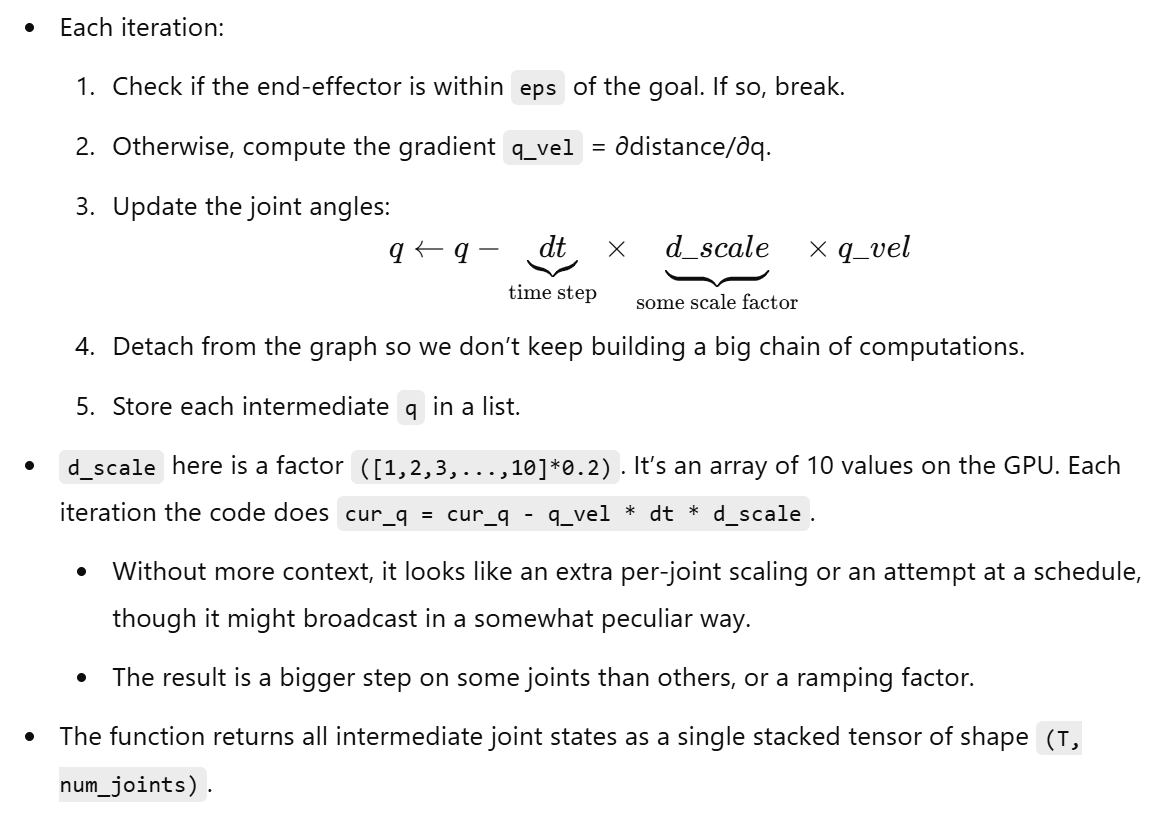

<H3> follow_traj: </H3>

* If you have multiple desired goal points in 3D space (xs), you want the end-effector to “visit” them in sequence.
* for each goal:
1. Calls integrate_to_target to move from the current cur_q to the new x_goal.
2. Takes the final joint state of that move (q_vels[-1]) as the new cur_q.
3. Stores all intermediate states so you get a full joint trajectory from the very first start up to the final goal.

* The output is the entire path as a stacked tensor, shape (T_total, num_joints), where T_total is the sum of all the steps from each sub-move.



In [23]:
import pytorch_kinematics as pk
class controller:
    def __init__(self, robot_urdf_path, eef_name):
        self.chain = pk.build_serial_chain_from_urdf(
            open(robot_urdf_path).read(), eef_name
        )
        self.chain = self.chain.to(device=device)

    def attractor_dist(self, q, x_goal):
        q.requires_grad_()
        eef_pose = self.chain.forward_kinematics(q)
        eef_pos = eef_pose.get_matrix()[0, :3, 3]
        return torch.norm(eef_pos - x_goal)

    def get_vel_q(self, q, x_goal):
        dist = self.attractor_dist(q, x_goal)
        q_vel = torch.autograd.grad(dist, q, create_graph=True)[0]
        return q_vel

    def integrate_to_target(self, q, x_goal, max_t=1000, dt=0.025, eps=0.05):
        cur_q = q.clone()
        q_list = [cur_q]
        d_scale=((torch.arange(0,10)+1)*0.2).to(device)
        for i in range(max_t):
            eef_pose = self.chain.forward_kinematics(cur_q)
            eef_pos = eef_pose.get_matrix()[0, :3, 3]
            if torch.norm(eef_pos - x_goal) < eps:
                break
            q_vel = self.get_vel_q(cur_q, x_goal)
            cur_q = cur_q - q_vel *dt*d_scale
            cur_q = cur_q.detach()
            q_list.append(cur_q[None].clone())
        return torch.vstack(q_list)

    def follow_traj(self, q_init, xs, max_t=500, dt=0.02, eps=0.03):
        cur_q = q_init.clone()
        q_all_list = []
        for goal_ind in range(len(xs)):
            x_goal = xs[goal_ind]
            q_vels = self.integrate_to_target(
                cur_q, x_goal, max_t=max_t, dt=dt, eps=eps
            )
            cur_q = q_vels[-1]
            q_all_list.append(q_vels[:].detach().clone())
        return torch.vstack(q_all_list)


<H1> Creating the Controller Instance: </H1>

* Loads the URDF of a “mobile Panda with gripper” robot.
* Sets the end-effector link to "panda_grasptarget" for forward kinematics.


In [24]:
urdf_path="urdf/mobilePandaWithGripper.urdf"
eef_n="panda_grasptarget"
contr=controller(urdf_path,eef_n)

Unknown tag "inertial" in /robot[@name='mobilePanda']


<H1> Using the Controller: </H1>

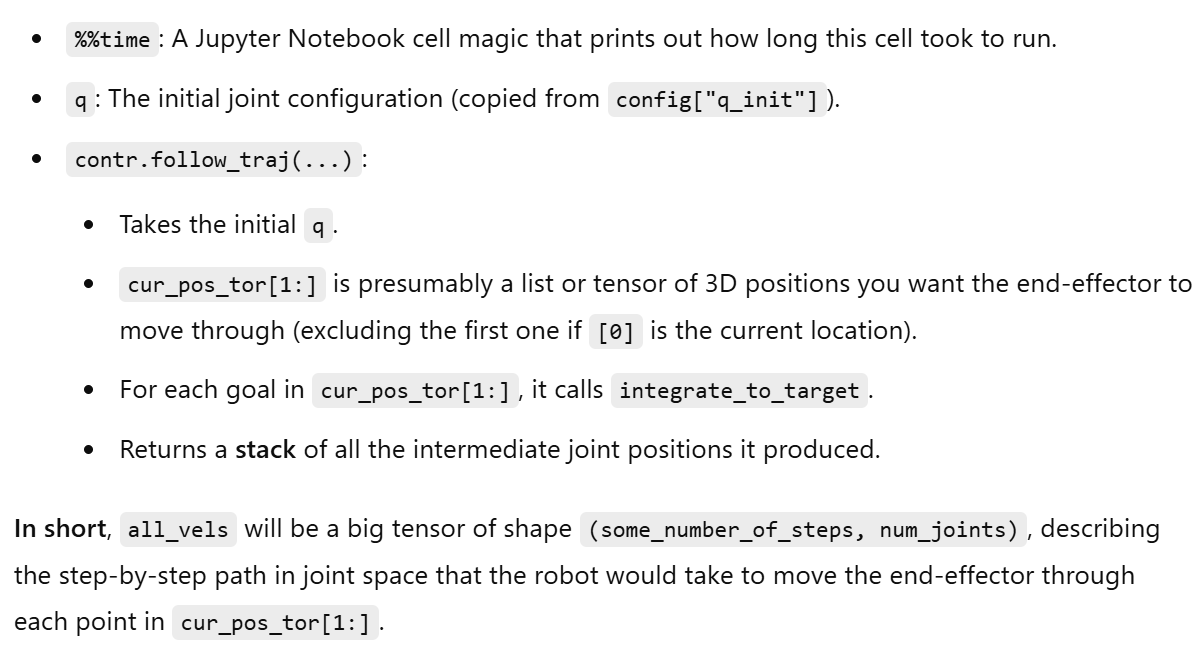

In [25]:
%%time
q=torch.tensor(config["q_init"], requires_grad=True).to(device)
all_vels=contr.follow_traj(q,cur_pos_tor[1:],max_t=500,dt=0.03,eps=0.04)

CPU times: total: 1.52 s
Wall time: 25.5 s


In [30]:
all_vels.shape

torch.Size([10])


torch.Size([238, 10])

In [18]:
# cl_env.simple_reset()
# cl_env._robot.reset(q.cpu().detach(), np.zeros(7))
# eef_id=cl_env._robot.eef_uid
# pos_eef=torch.tensor(p.getLinkState(0,eef_id)[-2])
# start_p=pos_eef.to(device)#mean_tor[0].to(device)
# #trajs_generated=trajectory_dist.condition_start(start_p,5,30)
# item_list=setup_env_bullet(y_vals_cur)

In [27]:
cur_joint_position=all_vels[0]
time.sleep(0.01)
ind=0
for i in range(0,len(cur_joint_position)):
    _, joint_name, joint_type, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = p.getJointInfo(cl_env._robot.robot_uid, ind)
    if(joint_type==4):
        ind=ind+1
    cl_env._p.resetJointState(cl_env._robot.robot_uid,ind,cur_joint_position[i])
    ind=ind+1

In [28]:
for ll in range(len(all_vels)):
    cur_joint_position=all_vels[ll]
    time.sleep(0.01)
    ind=0
    for i in range(0,len(cur_joint_position)):
        _, joint_name, joint_type, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = p.getJointInfo(cl_env._robot.robot_uid, ind)
        if(joint_type==4):
            ind=ind+1
        cl_env._p.resetJointState(cl_env._robot.robot_uid,ind,cur_joint_position[i])
        ind=ind+1

<H1> Notes on where trajectories are held: </H1>

* The trajectories are stored in the all_vels variable

<H3> Columns: </H3>

0. Column 0: Mobile base 𝑥 position
1. Column 1: Mobile base 𝑦 position
2. Column 2: Panda joint 1
3. Column 3: Panda joint 2
4. Column 4: Panda joint 3
5. Column 5: Panda joint 4
6. Column 6: Panda joint 5
7. Column 7: Panda joint 6
8. Column 8: Panda joint 7
9. Column 9: Gripper (open/close value)